In [357]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
import plotly.express as px
import plotly.graph_objects as go

In [358]:
df = pd.read_csv("/home/lucasleao/bootstrapping-intervals/data/risk_factors_cervical_cancer.csv")

# Exemplo de uso:
data = df[df["Dx:Cancer"] == 1]["Age"]
num_samples = len(data)
num_iterations = 1000

In [359]:
def generate_ci_graph(data, estimated_statistic, ci, confidence_level, fig_type=None):
    """
    Generates a histogram with a line indicating the mean and a confidence interval bar.

    Parameters:
    - data (list or array): Dataset to be plotted in the histogram.
    - estimated_statistic (float): Estimated statistic (e.g., mean) to be marked on the histogram.
    - ci (tuple): Pair of values representing the confidence interval (lower and upper limits).
    - confidence_level (float): Confidence level of the interval (e.g., 0.95 for 95%).
    - fig_type (str, optional): Type of figure to be displayed (default is None).

    Returns:
    - fig (plotly.graph_objects.Figure): Plotly figure object with the histogram and annotations.

    Example of usage:
    >>> generate_ci_graph(data, 5.0, (3.0, 7.0), 0.95)
    """

    fig = px.histogram(data, opacity=0.5)
    
    # Add line indicating the estimated statistic
    fig.add_vline(x=estimated_statistic, line_dash='dash', line_color='firebrick')
    
    # Add confidence interval bar
    fig.add_vrect(x0=ci[0], x1=ci[1], line_width=0, fillcolor='lightgrey', opacity=0.5)
    
    # Add invisible trace for confidence interval legend entry
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color='lightgrey'), showlegend=True, name=f'Confidence Interval {confidence_level * 100}%'))
    
    # Add annotations for lower and upper confidence interval limits
    fig.add_annotation(x=ci[0], y=confidence_level, xref='x', yref='paper', text=ci[0], showarrow=True, arrowhead=0, ax=0, ay=-30)
    fig.add_annotation(x=ci[1], y=confidence_level, xref='x', yref='paper', text=ci[1], showarrow=True, arrowhead=0, ax=0, ay=-30)
    fig.update_layout(title="Data Distribution with Confidence Interval", width=800, height=500)
    return fig.show(fig_type)


Boostrapping Normal Interval Confidence

In [360]:
def bootstrapping_mean_std(data, num_samples, num_iterations=1000):
    """
    Perform bootstrapping on the given data to estimate the mean and standard deviation.

    Parameters:
    data (array-like): The input data for bootstrapping.
    num_samples (int): The number of samples to draw in each bootstrap iteration.
    num_iterations (int): The number of bootstrap iterations to perform.

    Returns:
    tuple: A tuple containing the mean and standard deviation of the bootstrap means.
    
    Purpose:
    This function aims to provide a robust estimate of the mean and its variability by performing
    bootstrapping. Bootstrapping is a statistical method that involves repeated random sampling
    with replacement from a dataset to approximate the distribution of a statistic.
    """
    np.random.seed(42)
    sample_means = np.zeros(num_iterations)
    sample_std_dev = np.zeros(num_iterations)

    for i in range(num_iterations):
        bootstrap_sample = np.random.choice(data, size=num_samples, replace=True)
        sample_means[i] = np.mean(bootstrap_sample)
        sample_std_dev[i] = np.std(bootstrap_sample)
    
    return sample_means.mean(), sample_std_dev.mean()

mean, std_dev = bootstrapping_mean_std(data, num_samples, num_iterations)


print(f"Estimated Mean: {mean}")
print(f"Estimated Standard Deviation: {std_dev}")

Estimated Mean: 33.306444444444445
Estimated Standard Deviation: 7.643030665955143


In [361]:
def interval_confidence(confidence_level, std_dev, mean, n):
    """
    Calculates the margin of error and confidence interval for the mean of a sample.

    Parameters:
    - confidence_level (float): Desired confidence level (e.g., 0.95 for 95%).
    - std_dev (float): Standard deviation of the sample.
    - mean (float): Mean of the sample.
    - n (int): Sample size (number of observations).

    Returns:
    - float: The margin of error.
    - list: List containing the lower and upper bounds of the confidence interval rounded to two decimal places.
    """
    def se(std_dev, n):
        """
        Calculates the standard error of the mean.

        Parameters:
        - std_dev (float): Standard deviation of the sample.
        - n (int): Sample size (number of observations).

        Returns:
        - float: Standard error of the mean.
        """
        return std_dev / math.sqrt(n)

    # Calculates the z-score corresponding to the desired confidence level.
    z_score = norm.ppf((1 + confidence_level) / 2)
    se_value = se(std_dev, n) 
    margin_error = z_score * se_value

    return margin_error, [round(mean - margin_error, 2), round(mean + margin_error, 2)]

In [362]:
_, ci = interval_confidence(0.95, std_dev, mean, len(data))

In [363]:
def optimal_sample(confidence_level, std_dev, std_error):
    """
    Calculates the optimal sample size needed to achieve a desired standard error for a given confidence level and standard deviation.

    Parameters:
    - confidence_level (float): Desired confidence level (e.g., 0.95 for 95%).
    - std_dev (float): Standard deviation of the population.
    - std_error (float): Desired standard error of the mean.

    Returns:
    - int: The optimal sample size, rounded to the nearest integer.
    """
    z_score = norm.ppf((1 + confidence_level) / 2)  # Calculates the z-score corresponding to the desired confidence level.
    return round((z_score ** 2) * (std_dev ** 2) / (std_error ** 2))  # Calculates and returns the optimal sample size.

In [364]:
optimal_sample(0.90, std_dev, 1)

158

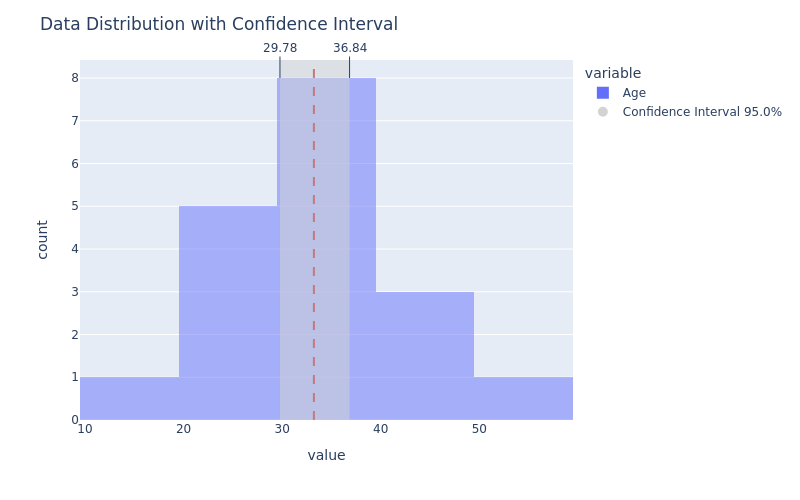

In [365]:
generate_ci_graph(data, data.mean(), ci, confidence_level=0.95, fig_type="png")

Boostrapping Percentile Interval Confidence

In [366]:
def bootstraping_percentile_confidence_interval(data, confidence_level, statistic=np.mean, num_iterations=1000):
    """
    Calculates the percentile bootstrap confidence interval for the mean of the given data.

    Parameters:
    - data (list or numpy array): Sample data.
    - confidence_level (float): Desired confidence level (e.g., 0.95 for 95%).
    - statistic (function): Statistical function to apply to the data. Default is np.mean.
    - num_resamples (int): Number of bootstrap resamples to perform. Default is 1000.

    Returns:
    - list: List containing the lower and upper bounds of the confidence interval rounded to two decimal places.
    """
    np.random.seed(42)
    
    def calculate_bootstrap_statistics(data, statistic, num_resamples=1000):
        """
        Performs bootstrap resampling on the given data and calculates the specified statistic for each resample.

        Parameters:
        - data (list or numpy array): Sample data.
        - statistic (function): Statistical function to apply to the data.
        - num_resamples (int): Number of bootstrap resamples to perform. Default is 1000.

        Returns:
        - numpy array: Array of calculated statistics for each bootstrap resample.
        """
        sample_statistics = np.zeros(num_resamples)
        
        for i in range(num_resamples):
            resample = np.random.choice(data, size=len(data), replace=True)
            sample_statistics[i] = statistic(resample)
        
        return sample_statistics

    # Calculate the point estimate
    theta_hat = round(statistic(data), 2)

    sample_statistics = calculate_bootstrap_statistics(data, statistic)

    # Calculating percentile interval
    lower_bound = np.percentile(sample_statistics, (1 - confidence_level) / 2 * 100)
    upper_bound = np.percentile(sample_statistics, (1 + confidence_level) / 2 * 100)
    
    return theta_hat, [round(lower_bound, 2), round(upper_bound, 2)]

In [367]:
estimated_statistic, ci = bootstraping_percentile_confidence_interval(data, 0.95)

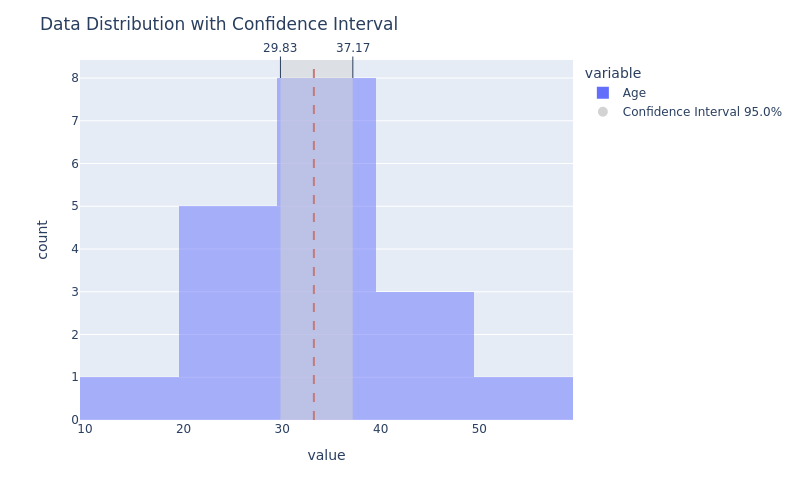

In [368]:
generate_ci_graph(data, estimated_statistic, ci, confidence_level=0.95, fig_type="png")

In [369]:
estimated_statistic, ci = bootstraping_percentile_confidence_interval(data, 0.95, np.std)

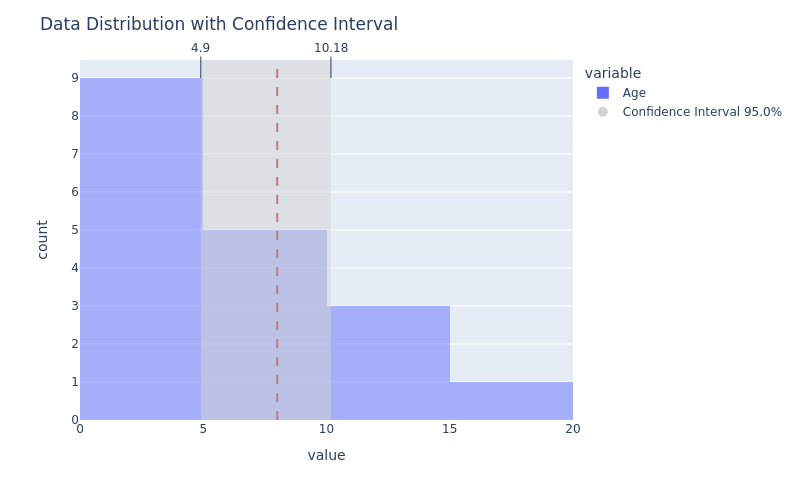

In [370]:
generate_ci_graph(np.sqrt((data.mean() - data) ** 2), estimated_statistic, ci, confidence_level=0.95, fig_type="png")

Better bootstrap confidence interval (BCa)

In [371]:
def bootstrapping_bca(data, confidence_level, statistic=np.mean, num_resamples=1000):
    """
    Calculates the bias-corrected and accelerated (BCa) bootstrap confidence interval for the given data.

    Parameters:
    - data (list or numpy array): Sample data.
    - confidence_level (float): Desired confidence level (e.g., 0.95 for 95%).
    - statistic (function): Statistical function to apply to the data. Default is np.mean.
    - num_resamples (int): Number of bootstrap resamples to perform. Default is 1000.

    Returns:
    - tuple: A tuple containing the point estimate and a list with the lower and upper bounds of the BCa confidence interval, rounded to two decimal places.
    """
    np.random.seed(42)
    
    def generate_acceleration(data):
        """
        Calculates the jackknife resampling means and returns the acceleration.

        Parameters:
        - data (list or numpy array): Sample data.

        Returns:
        - float: Acceleration value calculated from jackknife samples.
        """
        n = len(data)
        jackknife_means = np.zeros(n)
        
        for i in range(n):
            jackknife_sample = np.delete(data, i)  # Remove one observation
            jackknife_means[i] = np.mean(jackknife_sample)
        
        jackknife_mean = np.mean(jackknife_means)
        jackknife_diffs = jackknife_means - jackknife_mean
        acceleration = np.sum(jackknife_diffs ** 3) / (6.0 * (np.sum(jackknife_diffs ** 2) ** 1.5))
        
        return acceleration

    def calculate_bootstrap_statistics(data, statistic, num_resamples=1000):
        """
        Performs bootstrap resampling on the given data and calculates the specified statistic for each resample.

        Parameters:
        - data (list or numpy array): Sample data.
        - statistic (function): Statistical function to apply to the data.
        - num_resamples (int): Number of bootstrap resamples to perform. Default is 1000.

        Returns:
        - numpy array: Array of calculated statistics for each bootstrap resample.
        """
        sample_statistics = np.zeros(num_resamples)
        
        for i in range(num_resamples):
            resample = np.random.choice(data, size=len(data), replace=True)
            sample_statistics[i] = statistic(resample)
        
        return sample_statistics

    # Calculate the point estimate
    theta_hat = round(statistic(data), 2)

    # Bootstrap resampling 
    sample_statistics = calculate_bootstrap_statistics(data, statistic, num_resamples)
    
    # Bias correction
    observed_stat = statistic(data)
    bias_correction = np.sum(sample_statistics < observed_stat) / num_resamples
    
    # Jackknife resampling
    acceleration = generate_acceleration(data)
    
    # Calculating BCa interval
    z0 = norm.ppf(bias_correction)
    z_alpha = norm.ppf((1 + confidence_level) / 2)
    lower_bound = np.percentile(sample_statistics, norm.cdf(z0 + (z0 - z_alpha) / (1 - acceleration * (z0 - z_alpha))) * 100)
    upper_bound = np.percentile(sample_statistics, norm.cdf(z0 + (z0 + z_alpha) / (1 + acceleration * (z0 + z_alpha))) * 100)
    
    return theta_hat, [round(lower_bound, 2), round(upper_bound, 2)]


In [372]:
# Definir a estatística de interesse (por exemplo, média)
estimated_statistic, ci = bootstrapping_bca(data.values, 0.95, np.mean)

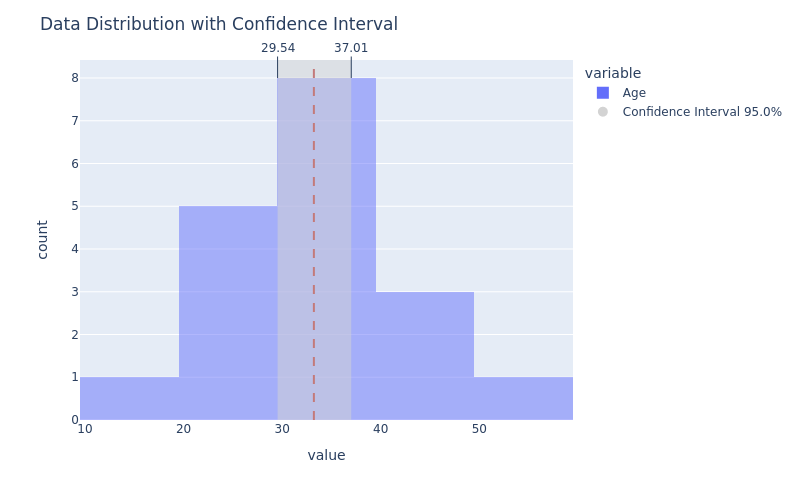

In [373]:
generate_ci_graph(data, estimated_statistic, ci, confidence_level=0.95, fig_type="png")

In [ ]:
estimated_statistic, ci = bootstrapping_bca(data.values, 0.95, np.std)

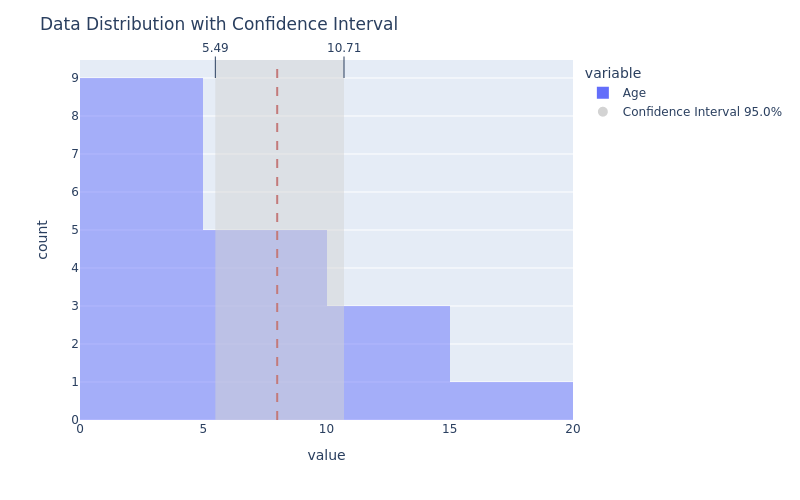

In [375]:
generate_ci_graph(np.sqrt((data.mean() - data) ** 2), estimated_statistic, ci, confidence_level=0.95, fig_type="png")

Studentized Confidence Interval

In [376]:
def bootstrapping_studentized_confidence_interval(data, confidence_level, statistic=np.mean, num_iterations=1000):
    """
    Calculates the studentized bootstrap confidence interval for the given data using the specified statistic.

    Parameters:
    - data (list or numpy array): Sample data.
    - confidence_level (float): Desired confidence level (e.g., 0.95 for 95%).
    - statistic (function): Statistical function to apply to the data. Default is np.mean.
    - num_iterations (int): Number of bootstrap resamples to perform. Default is 1000.

    Returns:
    - list: List containing the lower and upper bounds of the studentized bootstrap confidence interval rounded to two decimal places.
    """
    np.random.seed(42)
    n = len(data)
    
    def calculate_bootstrap_statistics(data, statistic, num_iterations, n):
        """
        Performs bootstrap resampling on the given data, calculates the specified statistic for each resample,
        and computes the standard error for each resample statistic.

        Parameters:
        - data (list or numpy array): Sample data.
        - statistic (function): Statistical function to apply to the data.
        - num_iterations (int): Number of bootstrap resamples to perform.
        - n (int): Size of the sample data.

        Returns:
        - tuple: Two numpy arrays containing the bootstrap resample statistics and their standard errors.
        """
        sample_stats = np.zeros(num_iterations)
        sample_stds = np.zeros(num_iterations)
        
        for i in range(num_iterations):
            resample = np.random.choice(data, size=n, replace=True)
            sample_stats[i] = statistic(resample)
            sample_stds[i] = np.std(resample, ddof=1) / np.sqrt(n)  # Standard error of the resample statistic
        
        return sample_stats, sample_stds

    # Bootstrap resampling and statistics calculation
    sample_stats, sample_stds = calculate_bootstrap_statistics(data, statistic, num_iterations, n)
    
    theta_hat = statistic(data)
    theta_std = np.std(data, ddof=1) / np.sqrt(n)
    t_values = (sample_stats - theta_hat) / sample_stds
    
    lower_percentile = np.percentile(t_values, (1 - confidence_level) / 2 * 100)
    upper_percentile = np.percentile(t_values, (1 + confidence_level) / 2 * 100)
    
    lower_bound = theta_hat - upper_percentile * theta_std
    upper_bound = theta_hat - lower_percentile * theta_std
    
    return theta_hat, [round(lower_bound, 2), round(upper_bound, 2)]


In [377]:
estimated_statistic, ci = bootstrapping_studentized_confidence_interval(data, 0.95)

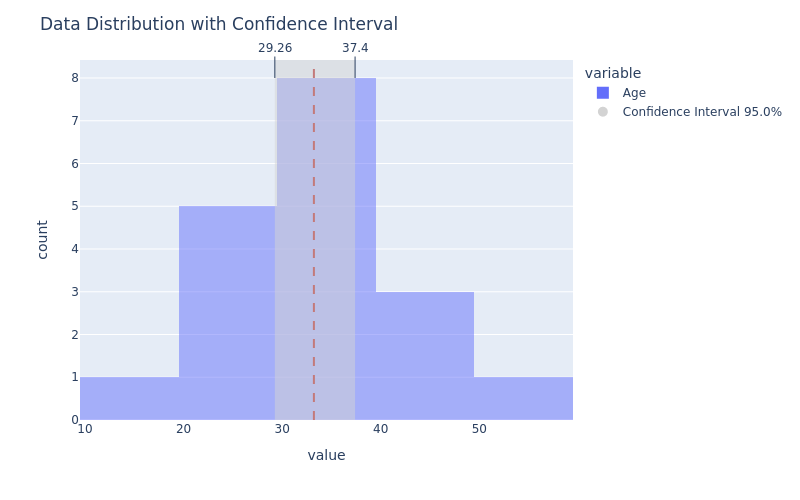

In [378]:
generate_ci_graph(data, estimated_statistic, ci, confidence_level=0.95, fig_type="png")

In [379]:
estimated_statistic, ci = bootstrapping_studentized_confidence_interval(data, 0.95, np.std)

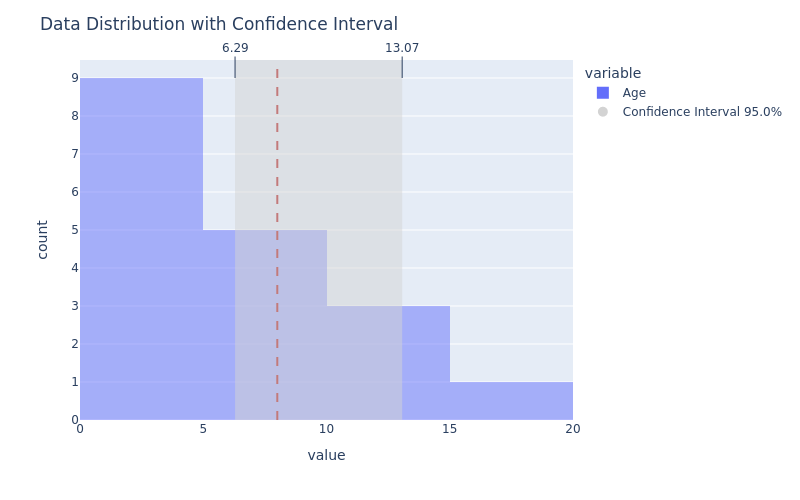

In [380]:
generate_ci_graph(np.sqrt((data.mean() - data) ** 2), estimated_statistic, ci, confidence_level=0.95, fig_type="png")